## Construct Causal Graph among the alerts where the alerts form the nodes and edges between the alerts indicate that one alert caused the other alert

1. Create a dataset where each row represents a 15 minute interval
2. Each column represent a distinct alert ID and whether it is . An extra column is added which represents whether a CSO is present or not in that time interval.
3. Some alert columns and rows are filtered out that does not contain enough information
4. Finally, PC algorithm is run on the binary time series data to build a causal graph

In [1]:
# pip install ./causal-learn
## assuming our modified causal-learn installed

In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import csv
from datetime import datetime, timedelta
from causallearn.utils.cit import chisq
from causallearn.search.ConstraintBased import PC
from copy import deepcopy
import networkx as nx
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn import feature_selection      ## mutual information
import pickle
import os
import shutil

In [2]:
dir = './causal_graph_data'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

In [20]:
df_all_alerts_parsed = pd.read_csv('./Alerts_data/all_alerts_parsed.csv', index_col=0)
df_all_alerts_parsed['time_r'] = (pd.to_datetime(df_all_alerts_parsed['created_at']).round('15T')).astype(str)
df_all_alerts_parsed['created_at'] = pd.to_datetime(df_all_alerts_parsed['created_at'])
no_of_alerts = len(df_all_alerts_parsed['time_r'])

alert_map = pd.read_csv('./Alerts_data/alert_id_mapping.csv', index_col=0)
unique_alerts = alert_map['id'].to_numpy()

In [4]:
alert_map

,alert_name,id
0,quartz_scheduler_down_alert,0
1,qpid shardau1toeu1q queuesize,1
2,Splunk Alert: TechOps - JMS Send Failure,2
3,app server load5 is high,3
4,Pingdom check Adobe Sign DNS Test,4
...,...,...
932,high_qpid_queuesize_agreementeventpublisherq_a...,932
933,splunk_process_down_alert,933
934,linuxtaskworker_process_down_alert,934
935,advancedworkflowsconnect_5xx_jp1,935


In [21]:
df_all_alerts_parsed = df_all_alerts_parsed.sort_values(by='created_at').reset_index(drop=True)

In [22]:
df_all_alerts_parsed['created_at']

0       2020-02-27 18:06:33+00:00
1       2020-02-27 18:06:33+00:00
2       2020-02-27 18:09:10+00:00
3       2020-02-27 18:09:10+00:00
4       2020-02-27 20:01:15+00:00
                   ...           
50914   2022-07-19 07:40:52+00:00
50915   2022-07-19 07:44:22+00:00
50916   2022-07-19 07:47:25+00:00
50917   2022-07-19 08:28:51+00:00
50918   2022-07-19 09:11:17+00:00
Name: created_at, Length: 50919, dtype: datetime64[ns, UTC]

In [26]:
len(df_all_alerts_parsed['alert_id'].unique())

937

In [12]:
## dts contains 15 minute interval timestamps for times correspodning to the alert data we have
def datetime_range(start, end, delta):
    current = start
    while current <= end:
        yield current
        current += delta

dts = dict()
for i,dt in enumerate(datetime_range(datetime(2020, 2, 15, 12), datetime(2022, 7, 20, 12), timedelta(minutes=15))):
    dts[dt.strftime('%Y-%m-%d %H:%M:00+00:00')] = i

In [13]:
# Creating a binary time series with rows as 15 minute intervals and columns as the alert IDs
time_series = np.zeros((len(dts), len(unique_alerts)))          ## quite efficient implementation now
time_series = np.int_(time_series)

for j in range(no_of_alerts):
    i = df_all_alerts_parsed['alert_id'].iloc[j]
    time = df_all_alerts_parsed['time_r'].iloc[j]
    time_series[dts[time],i] = 1

In [15]:
time_series.shape

(85057, 937)

### CSO exists column

In [19]:
import json

json_file = './CSO_data/CSO_all_scraped_Sign.json'
with open(json_file, 'r') as f:
    data = json.load(f)

In [27]:
# For every 15 minute interval, does CSO exist or not during that interval
cso_series = np.zeros(len(dts))          ## quite efficient implementation now
cso_series = np.int_(cso_series)

for i in data.keys():
    start_time = pd.to_datetime(data[i]['primaryIncident']['u_cso_started']).round('15T')
    end_time = pd.to_datetime(data[i]['primaryIncident']['u_cso_ended']).round('15T')
    
    buffer_start_time = start_time - pd.Timedelta(hours=1)
    
    for j,dt in enumerate(datetime_range(buffer_start_time, end_time, timedelta(minutes=15))):
        time = dt.strftime('%Y-%m-%d %H:%M:00+00:00')
        try:
            cso_series[dts[time]] = 1
        except:
            continue


### Combine the two time series

In [34]:
time_series = np.append(time_series, cso_series.reshape(len(cso_series),1), axis=1)

In [11]:
# Filter those rows out where all the column values are 0, that is, no alert fired and no CSO occurred
### Not ingnoring all zero rows completely, keeping a percentage of zero rows. 

In [35]:
new_time_series = []
for i in range(time_series.shape[0]):
    sumi = 0
    for j in range(time_series.shape[1]):
        sumi += time_series[i, j]
    if sumi != 0:
        new_time_series.append(list(time_series[i,:]))
    else:
        if random.uniform(0,1) < 0.05 :             ## 5% of zero rows on average
            new_time_series.append(list(time_series[i,:]))

In [36]:
## new_time_series is a time series 2d array consisting alerts time series data, having all non-zero rows along with a percentage(5) of zero rows
new_time_series = np.array(new_time_series)

In [37]:
print(new_time_series.shape)

(25268, 938)


In [170]:
df = pd.DataFrame(new_time_series)

In [171]:
df = df.rename(columns={937: 'cso_exists'})

In [173]:
df.to_csv("./causal_graph_data/binary_series_" + str(len(unique_alerts)) +".csv")

In [172]:
df

,0,1,2,3,4,5,6,7,8,9,...,928,929,930,931,932,933,934,935,936,cso_exists
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Redundant Data Removal

In [132]:
df_binary_series = pd.read_csv("./causal_graph_data/binary_series_" + str(len(unique_alerts)) +".csv", index_col=0) # also reads the index column this way

### Remove alert columns which occur very less frequently when cso_exists = 0 and no such alerts must be present when cso_exist = 1

In [133]:
a1 = {}
df1 = df_binary_series[df_binary_series['cso_exists'] == 0]
for col in df1.columns:
    a1[col] = sum(df1[col])

In [134]:
a2 = {}
df2 = df_binary_series[df_binary_series['cso_exists'] == 1]
for col in df2.columns:
    a2[col] = sum(df2[col])

In [135]:
a1 = dict(sorted(a1.items(), key=lambda item: item[1]))
a2 = dict(sorted(a2.items(), key=lambda item: item[1]))

In [136]:
fa = []
for k,v in a1.items():
    if a2[k] == 0:
        if v < 10:
            fa.append(k)

In [137]:
len(fa)

608

In [138]:
df_binary_series_1 = df_binary_series.drop(fa, axis=1)

In [139]:
df_binary_series_1

,0,2,3,4,5,6,9,20,30,33,...,920,922,925,926,927,932,933,934,936,cso_exists
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Remove rows where no alerts when cso_exists = 1

In [144]:
df1 = df_binary_series_1[df_binary_series_1['cso_exists'] == 1]

In [145]:
df2_1 = df1.loc[df1.sum(axis=1) > 1]
x = df1.loc[df1.sum(axis=1) == 1]
df2_2 = x.sample(n = int(0.05*len(x)))
df2 = pd.concat([df2_1, df2_2], axis=0)

In [169]:
df_binary_series_reduced = pd.concat([df_binary_series_1[df_binary_series_1['cso_exists'] == 0], df2])

In [174]:
df_binary_series_reduced.to_csv("./causal_graph_data/binary_series_" + str(len(unique_alerts)) +"_filtered.csv")

## Run PC

In [27]:
df_binary_series_reduced = pd.read_csv("./causal_graph_data/binary_series_" + str(len(unique_alerts)) +"_filtered.csv", index_col=0)

In [28]:
df_binary_series_reduced = df_binary_series_reduced.drop('cso_exists', axis=1)

In [32]:
cg_node_alert_id_map = {i:c for i,c in enumerate(df_binary_series_reduced.columns)}

In [56]:
df_binary_series_numpy = df_binary_series_reduced.to_numpy()

In [57]:
df_binary_series_numpy.shape

(21830, 329)

In [34]:
# to get this causal graph, run the lines below, to build_again, pass True
def build_cg(build_again = False):
    global cg
    if build_again:
        cg = PC.pc(df_binary_series_numpy, 0.05, chisq, verbose=False, show_progress=True)
        with open('./causal_graph_data/cg_binary_pc.cg', 'wb') as f:
            pickle.dump(cg, f)
    else:
        f = open('./causal_graph_data/cg_binary_pc_filtered.cg', 'rb')
        cg = pickle.load(f)

build_cg(False)

In [35]:
cg.to_nx_graph() ## edges of G are as wanted, undirected edges taken twice in both the directions

#### Adding nodes to CG

#### Adding weights to the edges

Using p-score to add the weights, test - ssr based chi2 test

For later uses, adding a list of (lag,p-score) pairs

Since, time intervals are of 15 minutes, assuming lags to be confined within an hour, so maxlag = 10 which corresponds to lag of 150 minutes should be sufficient. Also since dependencis between alerts might be different, taking a universal lag doesn't make sense.



Since this is the description of the Granger Causality
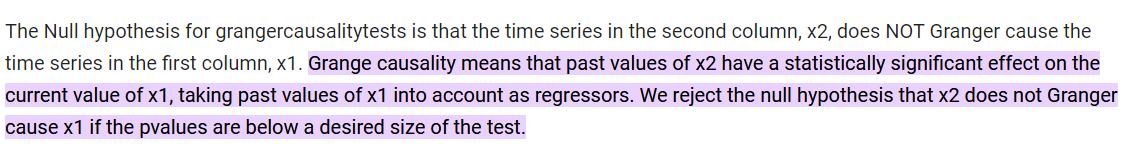

In causal graph, arrow from a->b taking it as a causes b

In [36]:
alert_id_mapping = pd.read_csv('./Alerts_data/alert_id_mapping.csv')
alert_id_dict = {}        ## key: id value: name
for i,alert in enumerate(alert_id_mapping['alert_name'].values):
    alert_id_dict[i] = alert

In [50]:
## for export creates a causal graph with unweighted edges
def create_cg_nx(g, max_lag):
    G = nx.DiGraph()
    kwargs = {}
    kwargs['color'] = 'cyan'
    kwargs['type'] = 'alert'
    for node in list(g.nx_graph.nodes()):
        a_id = int(cg_node_alert_id_map[node])
        kwargs['alert_id'] = a_id
        kwargs['label'] = alert_id_dict[a_id]
        G.add_node(node, **kwargs)
    color_dict = {'b':'blue', 'g': 'green', 'r': 'red'}
    kwargs = {}
    kwargs['label'] = 'causes'
    for edge in list(g.nx_graph.edges(data = True)):
        kwargs['color'] = color_dict[edge[2]['color']]
        G.add_edge(edge[0], edge[1], **kwargs)
    return G

In [52]:
## for export creates a causal graph with weighted edges, weight - mutual information
def create_cg_nx_mutual_info(g, max_lag):
    G = nx.DiGraph()
    kwargs = {}
    kwargs['color'] = 'cyan'
    kwargs['type'] = 'alert'
    for node in list(g.nx_graph.nodes()):
        a_id = int(cg_node_alert_id_map[node])
        kwargs['alert_id'] = a_id
        kwargs['label'] = alert_id_dict[a_id]
        G.add_node(node, **kwargs)
    color_dict = {'b':'blue', 'g': 'green', 'r': 'red'}
    kwargs = {}
    kwargs['label'] = 'causes'
    for edge in list(g.nx_graph.edges(data = True)):
        kwargs['color'] = color_dict[edge[2]['color']]
        lst = []
        mi = feature_selection.mutual_info_classif(np.reshape(df_binary_series_numpy[:, edge[0]], (-1,1)), df_binary_series_numpy[:, edge[1]])
        lst.append((0, mi[0]))
        for k in range(1, max_lag + 1):
            mi = feature_selection.mutual_info_classif(np.reshape(df_binary_series_numpy[:-k, edge[0]], (-1,1)), df_binary_series_numpy[k:, edge[1]])
            lst.append((k, mi[0]))
        # result = grangercausalitytests(df_binary_series_numpy[:,[edge[1],edge[0]]],10,True, False)
        # for i in result:
        #     lst.append((i-1 , 1 - result[i][0]['ssr_ftest'][1]))
        kwargs['weights'] = lst
        G.add_edge(edge[0], edge[1], **kwargs)
    return G

In [53]:
## for export creates a causal graph with weighted edges, weight - p value for ftest
def create_cg_nx_ftest(g, max_lag):
    G = nx.DiGraph()
    kwargs = {}
    kwargs['color'] = 'cyan'
    kwargs['type'] = 'alert'
    for node in list(g.nx_graph.nodes()):
        a_id = int(cg_node_alert_id_map[node])
        kwargs['alert_id'] = a_id
        kwargs['label'] = alert_id_dict[a_id]
        G.add_node(node, **kwargs)
    color_dict = {'b':'blue', 'g': 'green', 'r': 'red'}
    kwargs = {}
    kwargs['label'] = 'causes'
    for edge in list(g.nx_graph.edges(data = True)):
        kwargs['color'] = color_dict[edge[2]['color']]
        lst = []
        result = grangercausalitytests(df_binary_series_numpy[:,[edge[1],edge[0]]],10,True, False)
        for i in result:
            lst.append((i-1 , 1 - result[i][0]['ssr_ftest'][1]))
        kwargs['weights'] = lst
        G.add_edge(edge[0], edge[1], **kwargs)
    return G

In [54]:
## for export creates a causal graph with weighted edges, weight - p value for chi2test
def create_cg_nx_chi2test(g, max_lag):
    G = nx.DiGraph()
    kwargs = {}
    kwargs['color'] = 'cyan'
    kwargs['type'] = 'alert'
    for node in list(g.nx_graph.nodes()):
        a_id = int(cg_node_alert_id_map[node])
        kwargs['alert_id'] = a_id
        kwargs['label'] = alert_id_dict[a_id]
        G.add_node(node, **kwargs)
    color_dict = {'b':'blue', 'g': 'green', 'r': 'red'}
    kwargs = {}
    kwargs['label'] = 'causes'
    for edge in list(g.nx_graph.edges(data = True)):
        kwargs['color'] = color_dict[edge[2]['color']]
        lst = []
        result = grangercausalitytests(df_binary_series_numpy[:,[edge[1],edge[0]]],10,True, False)
        for i in result:
            lst.append((i-1 , 1 - result[i][0]['ssr_chi2test'][1]))
        kwargs['weights'] = lst
        G.add_edge(edge[0], edge[1], **kwargs)
    return G

In [48]:
max_lag = 10

In [51]:
G_unweighted = create_cg_nx(cg, max_lag)
nx.write_gpickle(G_unweighted, './causal_graph_data/cg_unweighted_filtered.gpickle')

In [58]:
G_mutual_info = create_cg_nx_mutual_info(cg, max_lag)
nx.write_gpickle(G_mutual_info, './causal_graph_data/cg_weighted_mutual_info_filtered.gpickle')

In [ ]:
G_ftest = create_cg_nx_ftest(cg, max_lag)
nx.write_gpickle(G_ftest , './causal_graph_data/cg_weighted_ftest_filtered.gpickle')

In [22]:
G_chi2test = create_cg_nx_chi2test(cg, max_lag)
nx.write_gpickle(G_chi2test, './causal_graph_data/cg_weighted_chi2test_filtered.gpickle')

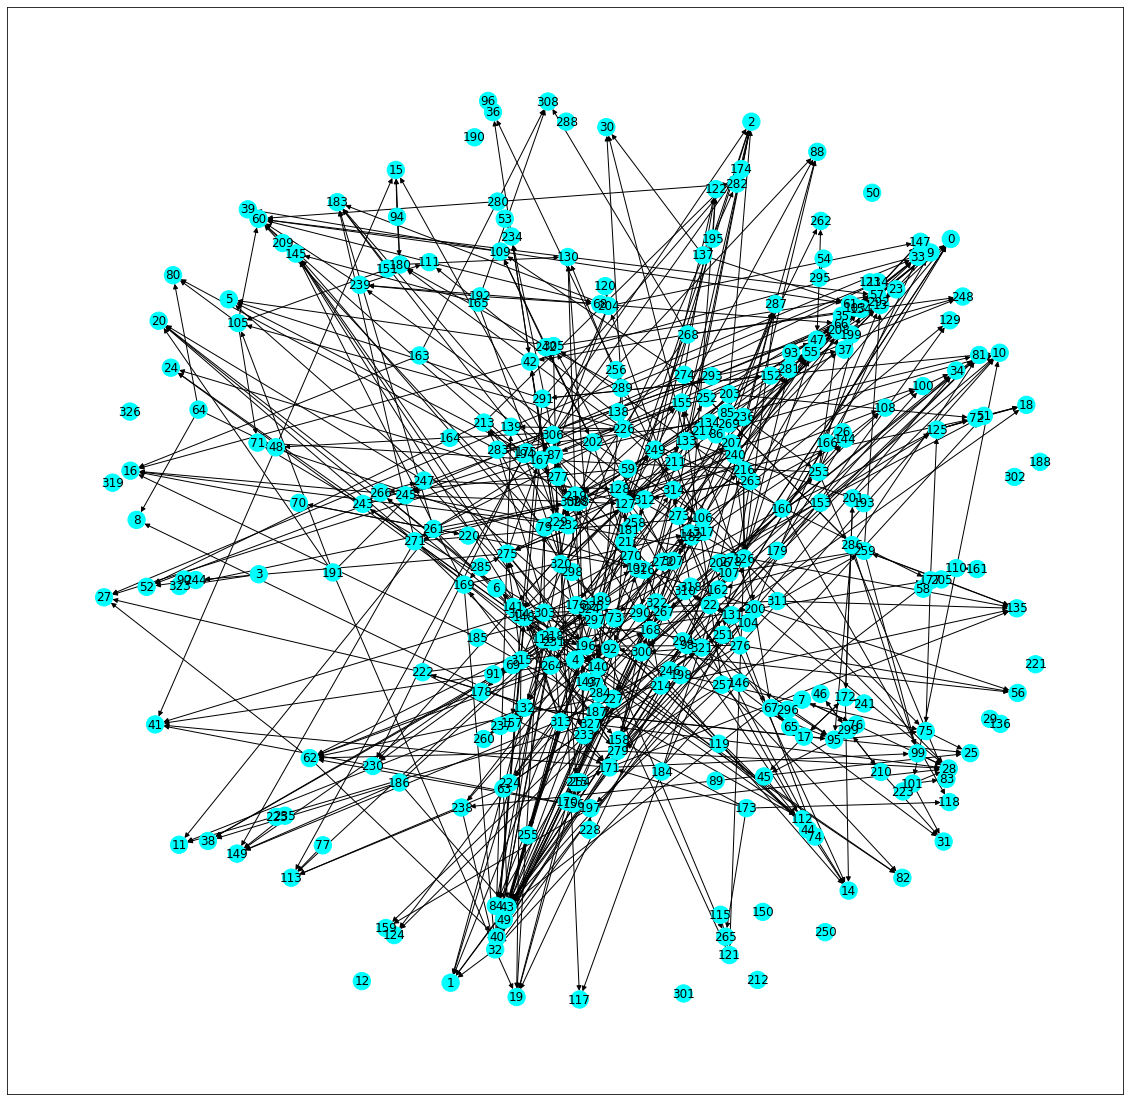

In [70]:
G = pickle.load(open('./causal_graph_data/cg_unweighted_filtered.gpickle', 'rb'))

color_map = [i[1]['color'] for i in list(G.nodes(data = True))]
edge_color = [i[2]['color'] for i in list(G.edges(data = True))]

plt.figure(2, figsize = (20,20))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos = pos, node_color=color_map)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
plt.savefig('CG_graph.jpg', dpi=400)